Jeff Sackmann data - 2000 to 2020

In [1]:
import time
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn import svm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.ticker as plticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [2]:
df = pd.read_csv('shortCombinedData.csv')
display(df.head())
df.shape

C:\Users\nivetha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2010-301,Auckland,Hard,28,A,20100111.0,1.0,103752,NaN,NaN,...,9.0,0.0,6.0,64.0,42.0,22.0,11.0,9.0,8.0,12.0
1,2010-301,Auckland,Hard,28,A,20100111.0,2.0,104545,NaN,NaN,...,5.0,5.0,5.0,89.0,56.0,37.0,22.0,15.0,4.0,7.0
2,2010-301,Auckland,Hard,28,A,20100111.0,3.0,104338,7.0,NaN,...,2.0,4.0,2.0,53.0,29.0,18.0,8.0,7.0,5.0,9.0
3,2010-301,Auckland,Hard,28,A,20100111.0,4.0,103967,NaN,Q,...,11.0,5.0,3.0,67.0,35.0,21.0,18.0,12.0,1.0,5.0
4,2010-301,Auckland,Hard,28,A,20100111.0,5.0,104907,NaN,WC,...,9.0,10.0,3.0,75.0,47.0,29.0,10.0,10.0,12.0,17.0


(53571, 49)

In [3]:
df.to_csv('combinedData.csv')

In [4]:
eval_df = pd.DataFrame(columns=["model", "recall", "accuracy", "precision"])
df = df.drop(columns=["tourney_id","tourney_name", "draw_size", "tourney_date", "match_num", "winner_id", "winner_seed", "tourney_level", "winner_ioc",\
                                    "winner_rank_points", "winner_entry","winner_name", "loser_id", "loser_seed", "loser_rank_points", "loser_entry", "loser_ioc",\
                                    "score", "round", "loser_name", "minutes","surface", "winner_hand", "winner_ht", "winner_age", "winner_rank", "loser_hand", "loser_ht",\
                                    "loser_age", "loser_rank" ])
df = df.dropna()
df.info()
filtered_df = df[(df.best_of == 3)]
df.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44451 entries, 0 to 53242
Data columns (total 19 columns):
best_of      44451 non-null float64
w_ace        44451 non-null float64
w_df         44451 non-null float64
w_svpt       44451 non-null float64
w_1stIn      44451 non-null float64
w_1stWon     44451 non-null float64
w_2ndWon     44451 non-null float64
w_SvGms      44451 non-null float64
w_bpSaved    44451 non-null float64
w_bpFaced    44451 non-null float64
l_ace        44451 non-null float64
l_df         44451 non-null float64
l_svpt       44451 non-null float64
l_1stIn      44451 non-null float64
l_1stWon     44451 non-null float64
l_2ndWon     44451 non-null float64
l_SvGms      44451 non-null float64
l_bpSaved    44451 non-null float64
l_bpFaced    44451 non-null float64
dtypes: float64(19)
memory usage: 6.8 MB


Index(['best_of', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced'],
      dtype='object')

In [5]:
lost_df = filtered_df[['l_ace', 'l_df', 'l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']]
won_df = filtered_df[['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon','w_SvGms', 'w_bpSaved', 'w_bpFaced']]
lost_df = lost_df.rename(columns={'l_ace':'ace', 'l_df':'df', 'l_svpt':'svpt','l_1stIn':'1stIn', 'l_1stWon':'1stWon', 'l_2ndWon':'2ndWon', \
                                  'l_SvGms':'SvGms', 'l_bpSaved':'bpSaved', 'l_bpFaced':'bpFaced'})
won_df = won_df.rename(columns={'w_ace':'ace', 'w_df':'df', 'w_svpt':'svpt','w_1stIn':'1stIn', 'w_1stWon':'1stWon', 'w_2ndWon':'2ndWon',\
                                'w_SvGms':'SvGms', 'w_bpSaved':'bpSaved', 'w_bpFaced':'bpFaced'})

won_df["won"] = won_df['svpt']**0
lost_df["won"] = lost_df['svpt']*0

big_df = pd.concat([won_df, lost_df], ignore_index=True)
big_df = big_df.drop(columns=['svpt'])
display(big_df.head())

,ace,df,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,won
0,2.0,4.0,31.0,25.0,14.0,9.0,8.0,9.0,1.0
1,11.0,2.0,56.0,45.0,17.0,15.0,3.0,5.0,1.0
2,6.0,3.0,28.0,25.0,8.0,8.0,2.0,2.0,1.0
3,1.0,4.0,56.0,34.0,20.0,13.0,7.0,11.0,1.0
4,1.0,4.0,48.0,33.0,10.0,10.0,7.0,9.0,1.0


In [6]:
big_df['won'].value_counts()

0.0    36252
1.0    36252
Name: won, dtype: int64

In [7]:
def split_test_train(train_size, all_data):
    msk = np.random.rand(len(all_data)) < train_size
    train_df = all_data[msk]
    test_df = all_data[~msk]
    train_y = train_df["won"]
    train_x = train_df.drop("won", axis=1)
    test_y = test_df["won"]
    test_x  = test_df.drop("won", axis=1)
    return (train_x, train_y, test_x, test_y)

In [8]:
def eval_for_conclusion(model_id, clf, test_x, test_y):
    y_pred = clf.predict(test_x)
    print(confusion_matrix(test_y, y_pred))
    accuracy = metrics.accuracy_score(test_y, y_pred)
    precision = metrics.precision_score(test_y, y_pred)
    recall = metrics.recall_score(test_y, y_pred)
    print("Final {0} model accuracy:".format(model_id), accuracy)
    print("Final {0} model precision:".format(model_id), precision) 
    print("Final {0} model recall:".format(model_id), recall) 
    return {"model":model_id, "recall":recall, "accuracy":accuracy, "precision":precision}

def cross_validate(all_data, model):
    depth = []
    all_y = all_data["won"]
    all_x  = all_data.drop("won", axis=1)
    for i in range(2,10):
        scores = cross_val_score(estimator=model, X=all_x, y=all_y, cv=i, n_jobs=4)
        depth.append((i,scores.mean()))
    return depth
    
def train_and_test(all_data, model):
    test_scores = []
    train_scores = []
    times = []
    for i in range(1,10):
        (train_x, train_y, test_x, test_y) = split_test_train(0.1 * i, big_df)
        start = time.time()
        model.fit(train_x, train_y)
        end = time.time()
        times.append(end - start)
        pred_test_y = model.predict(test_x) # TODO add wallclock time
        test_score = round(model.score(test_x, test_y) * 100, 2)
        pred_train_y = model.predict(train_x)
        train_score = round(model.score(train_x, train_y) * 100, 2)
        test_scores.append(test_score)
        train_scores.append(train_score)
    return (test_scores, train_scores, times)

def plot_data(x_vars, x_label, all_y_vars, y_var_labels, y_label, title, y_bounds=None):
    plt.rcParams["figure.figsize"] = (4,3)

    i = 0
    for y_var in all_y_vars:
        plt.plot(x_vars, y_var, label=y_var_labels[i])
        i += 1
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_bounds != None:
        plt.ylim(y_bounds)
    leg = plt.legend();
    plt.show()

def evaluate_model(all_data, model, model_id):
    (test_scores, train_scores, times) = train_and_test(all_data, model)
    cv_scores = cross_validate(all_data, model)
    """print("{0} train timings (seconds): {1}".format(model_id, times))"""
    print("{0} test set scores: {1} ".format(model_id, test_scores))
    print("{0} train set scores: {1}".format(model_id, train_scores))
    print("{0} cross validation set scores: {1}".format(model_id, cv_scores))
    plot_data([x * 10 for x in range(1,10)], "Percentage of data in training set", [test_scores, train_scores],\
              ["test_scores", "train_scores"], "Accuracy", "{0} Accuracy Over Train/Test Split".format(model_id), (50,103))
    plot_data([x[0] for x in cv_scores], "Number of folds", [[x[1] for x in cv_scores]],
             ["cross_validation_accuracy"], "Accuracy", "{0} Accuracy Over Different Cross Validation Values of K".format(model_id), (0.3,1))
    return (test_scores, train_scores, times, cv_scores)

def plot_grid_search(grid_results, plotting_func, title, x_label, y_label, grid_size, model_handles):
    plt.rcParams["figure.figsize"] = grid_size
    means = grid_results.cv_results_['mean_test_score']
    stds = grid_results.cv_results_['std_test_score']
    params = grid_results.cv_results_['params']
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.subplots
    ax = plt.subplot()
    for mean, std, params in zip(means, stds, params):
        plotting_func(mean, params, plt, ax)
    if handles: plt.legend(handles=model_handles)
    plt.show()


Decision Tree test set scores: [71.79, 72.35, 72.97, 73.33, 73.12, 73.7, 73.89, 73.15, 72.84] 
Decision Tree train set scores: [100.0, 99.99, 99.97, 99.97, 99.97, 99.97, 99.96, 99.97, 99.96]
Decision Tree cross validation set scores: [(2, 0.7319458236786935), (3, 0.7322492552135055), (4, 0.7325802714333002), (5, 0.7342767085633849), (6, 0.7323320092684543), (7, 0.7322629774611852), (8, 0.7311458325825639), (9, 0.7330767957629925)]


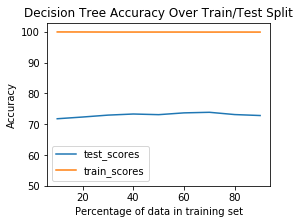

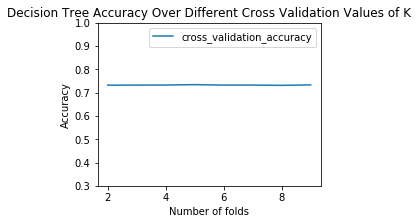

In [9]:
dt_model = DecisionTreeClassifier()
(dt_test_scores, dt_train_scores, dt_times, dt_cv_scores) = evaluate_model(big_df, dt_model, "Decision Tree")
optimal_test_split = dt_test_scores.index(max(dt_test_scores)) * 0.1
(dt_grid_train_x, dt_grid_train_y, dt_grid_test_x, dt_grid_test_y) = split_test_train(optimal_test_split, big_df)


dt_param_grid = {"criterion":["gini","entropy"], "max_depth":[x for x in range(2,31)], "min_samples_split":[3,5,7]}  #"splitter":["best", "random"], 

dt_grid_results = GridSearchCV(dt_model, dt_param_grid, cv=5).fit(dt_grid_train_x, dt_grid_train_y)

In [10]:
print(confusion_matrix(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x)))
print("DT model accuracy:", metrics.accuracy_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 
print("DT model precision:", metrics.precision_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 
print("DT model recall:", metrics.recall_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 

[[12021  2561]
 [ 3724 10729]]
DT model accuracy: 0.7835371103840193
DT model precision: 0.8072987208427389
DT model recall: 0.7423372310247007


KNN test set scores: [73.83, 74.27, 74.45, 74.5, 74.71, 74.79, 74.65, 75.55, 75.19] 
KNN train set scores: [82.63, 82.91, 82.87, 83.09, 83.15, 83.15, 83.34, 83.13, 83.44]
KNN cross validation set scores: [(2, 0.7482621648460774), (3, 0.750524109014675), (4, 0.750151715767406), (5, 0.7508963101403374), (6, 0.7521791901136489), (7, 0.7511583516797327), (8, 0.7511995853123612), (9, 0.7515309500165508)]


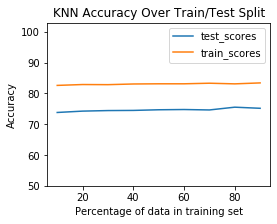

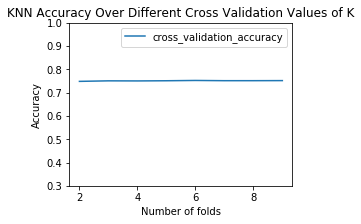

Best parameters found:
 {'n_neighbors': 80} with score of:  0.7700412118703982
[[5333 1996]
 [1370 5812]]
Final KNN model accuracy: 0.7680380401075046
Final KNN model precision: 0.7443647540983607
Final KNN model recall: 0.809245335561125


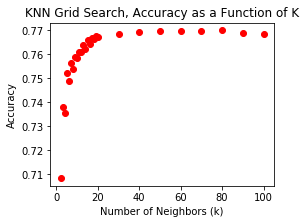

In [11]:
knn_classifier = KNeighborsClassifier()
evaluate_model(big_df, knn_classifier, "KNN")
knn_param_grid = {"n_neighbors":[x for x in range (2,21)] + [y*10 for y in range(3,11)]}
(knn_grid_train_x, knn_grid_train_y, knn_grid_test_x, knn_grid_test_y) = split_test_train(0.8, big_df)
knn_grid_results = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5).fit(knn_grid_train_x, knn_grid_train_y)

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Grid Search, Accuracy as a Function of K")
knn_means = knn_grid_results.cv_results_['mean_test_score']
knn_stds = knn_grid_results.cv_results_['std_test_score']
knn_params = knn_grid_results.cv_results_['params']
k_vals = []
knn_accuracies = []
for mean, std, params in zip(knn_means, knn_stds, knn_params):
    knn_accuracies.append(mean)
    k_vals.append(params["n_neighbors"])
print('Best parameters found:\n', knn_grid_results.best_params_, "with score of: ", max(knn_grid_results.cv_results_['mean_test_score']))

    
eval_for_conclusion("KNN", knn_grid_results, knn_grid_test_x, knn_grid_test_y)

    
plt.plot(k_vals, knn_accuracies, 'o', color="red")
plt.show()    

C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: Fut

SVM test set scores: [74.5, 75.5, 75.75, 76.59, 76.61, 76.73, 76.79, 77.68, 76.89] 
SVM train set scores: [97.77, 95.94, 94.97, 94.29, 93.81, 93.19, 93.0, 92.47, 92.26]
SVM cross validation set scores: [(2, 0.7668956195520247), (3, 0.7676541983890545), (4, 0.7693644488579939), (5, 0.7699021566585346), (6, 0.7704816285998014), (7, 0.7717917182107288), (8, 0.7721502557745281), (9, 0.7716126006841002)]


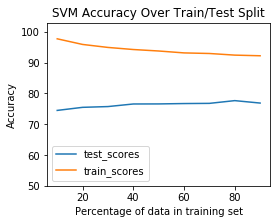

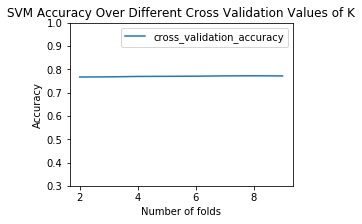

([74.5, 75.5, 75.75, 76.59, 76.61, 76.73, 76.79, 77.68, 76.89],
 [97.77, 95.94, 94.97, 94.29, 93.81, 93.19, 93.0, 92.47, 92.26],
 [5.619107961654663,
  36.419270753860474,
  93.50178861618042,
  152.49496865272522,
  215.74432563781738,
  302.6930115222931,
  127.6664526462555,
  162.445209980011,
  204.69728994369507],
 [(2, 0.7668956195520247),
  (3, 0.7676541983890545),
  (4, 0.7693644488579939),
  (5, 0.7699021566585346),
  (6, 0.7704816285998014),
  (7, 0.7717917182107288),
  (8, 0.7721502557745281),
  (9, 0.7716126006841002)])

In [12]:
svm_classifier = svm.SVC()
evaluate_model(big_df, svm_classifier, "SVM")

In [13]:
svm_parameter_space = {
    'kernel': ['linear', 'rbf'],
    'C': [ float(i) / 100 for i in range (1, 300, 5)]+[5,7,9],    
}
svm_grid_clf = GridSearchCV(svm_classifier, svm_parameter_space, n_jobs=-1, cv=3)
(svm_train_x, svm_train_y, svm_test_x, svm_test_y) = split_test_train(0.1 * 8, big_df)
scaler = StandardScaler()
scaler.fit(svm_train_x)
svm_train_x = scaler.transform(svm_train_x)
svm_test_x = scaler.transform(svm_test_x)
svm_grid_clf.fit(svm_train_x, svm_train_y)

print("best params ", svm_grid_clf.best_params_)
svm_grid_score = svm_grid_clf.score(svm_test_x,svm_test_y)
print("SVM grid search model test set score: ", svm_grid_score)
print('Best SVM parameters found (cv):\n', svm_grid_clf.best_params_, "with score of: ", max(svm_grid_clf.cv_results_['mean_test_score']))


best params  {'C': 2.66, 'kernel': 'rbf'}
SVM grid search model test set score:  0.7933027011974381
Best SVM parameters found (cv):
 {'C': 2.66, 'kernel': 'rbf'} with score of:  0.7965256277949776


Adaboost test set scores: [77.63, 77.9, 77.8, 77.76, 78.03, 77.95, 77.17, 77.86, 77.51] 
Adaboost train set scores: [77.95, 77.89, 77.95, 77.67, 78.06, 77.96, 78.02, 78.04, 78.08]
Adaboost cross validation set scores: [(2, 0.7789087498620766), (3, 0.7790190886020082), (4, 0.7784811872448417), (5, 0.7791018865412143), (6, 0.7792535584243628), (7, 0.7791156202925074), (8, 0.7788120622852516), (9, 0.7794742359042259)]


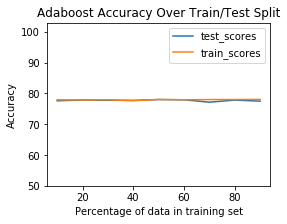

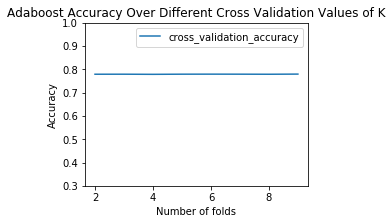

([77.63, 77.9, 77.8, 77.76, 78.03, 77.95, 77.17, 77.86, 77.51],
 [77.95, 77.89, 77.95, 77.67, 78.06, 77.96, 78.02, 78.04, 78.08],
 [0.17852210998535156,
  0.29625678062438965,
  0.42391443252563477,
  0.5883400440216064,
  0.7240703105926514,
  0.9720561504364014,
  0.9809489250183105,
  1.1275532245635986,
  1.3181657791137695],
 [(2, 0.7789087498620766),
  (3, 0.7790190886020082),
  (4, 0.7784811872448417),
  (5, 0.7791018865412143),
  (6, 0.7792535584243628),
  (7, 0.7791156202925074),
  (8, 0.7788120622852516),
  (9, 0.7794742359042259)])

In [14]:
boost_classifier = AdaBoostClassifier()
evaluate_model(big_df, boost_classifier, "Adaboost")

In [15]:
boost_parameter_space = {
    'n_estimators': [i*10 for i in range(5,11)],
    'learning_rate': [ float(i) / 100 for i in range (1, 150, 10)]
}
boost_grid_clf = GridSearchCV(boost_classifier, boost_parameter_space, n_jobs=-1, cv=3)
(boost_train_x, boost_train_y, boost_test_x, boost_test_y) = split_test_train(0.1 * 8, big_df)
scaler = StandardScaler()
scaler.fit(boost_train_x)
boost_train_x = scaler.transform(boost_train_x)
boost_test_x = scaler.transform(boost_test_x)
boost_grid_clf.fit(boost_train_x, boost_train_y)

print("best Boost params ", boost_grid_clf.best_params_)
boost_grid_score = boost_grid_clf.score(boost_test_x,boost_test_y)
print("Bost grid search model test set score: ", boost_grid_score)
print('Best Boost parameters found through cv:\n', boost_grid_clf.best_params_, "with score of: ", max(boost_grid_clf.cv_results_['mean_test_score']))


best Boost params  {'learning_rate': 1.41, 'n_estimators': 90}
Bost grid search model test set score:  0.7850544036132211
Best Boost parameters found through cv:
 {'learning_rate': 1.41, 'n_estimators': 90} with score of:  0.7882054205316888


In [16]:
def plotting_func_boost(mean, params, plt, ax):
    x_var = "learning_rate"
    cmap = cm.hot
    norm = Normalize(vmin=-110, vmax=-20)
    ax.plot(params[x_var], mean,"o", color=cmap(norm(-1*params["n_estimators"])))
    
cmap = cm.hot
norm = Normalize(vmin=-110, vmax=-20)
yellow_patch = mpatches.Patch(color=cmap(norm(-50)), label='n_estimators=50')
red_patch = mpatches.Patch(color=cmap(norm(-80)), label='n_estimators=80')
black_patch = mpatches.Patch(color=cmap(norm(-110)), label='n_estimators=110')
handles = [yellow_patch, red_patch, black_patch] #[linear, rbf]#, red_patch, orange_patch, black_patch]



eval_for_conclusion("AdaBoosting", boost_grid_clf, boost_test_x, boost_test_y)


[[5736 1628]
 [1513 5736]]
Final AdaBoosting model accuracy: 0.7850544036132211
Final AdaBoosting model precision: 0.7789244975556763
Final AdaBoosting model recall: 0.7912815560767003


{'model': 'AdaBoosting',
 'recall': 0.7912815560767003,
 'accuracy': 0.7850544036132211,
 'precision': 0.7789244975556763}

In [20]:
eval_df = pd.DataFrame(columns=["model", "accuracy", "recall", "precision"])
print("Confusion Matrix for Decision Tree")
eval_df = eval_df.append(eval_for_conclusion("Decision Tree", dt_grid_results, dt_grid_test_x, dt_grid_test_y), ignore_index=True)
print("\n\nConfusion Matrix for SVM")
eval_df = eval_df.append(eval_for_conclusion("SVM", svm_grid_clf, svm_test_x, svm_test_y), ignore_index=True)
print("\n\nConfusion Matrix for AdaBoosting")
eval_df = eval_df.append(eval_for_conclusion("AdaBoosting", boost_grid_clf, boost_test_x, boost_test_y), ignore_index=True)
print("\n\nConfusion Matrix for KNN")
eval_df = eval_df.append(eval_for_conclusion("KNN", knn_grid_results, knn_grid_test_x, knn_grid_test_y), ignore_index=True)
eval_df.head()

Confusion Matrix for Decision Tree
[[12021  2561]
 [ 3724 10729]]
Final Decision Tree model accuracy: 0.7835371103840193
Final Decision Tree model precision: 0.8072987208427389
Final Decision Tree model recall: 0.7423372310247007


Confusion Matrix for SVM
[[5634 1557]
 [1412 5761]]
Final SVM model accuracy: 0.7933027011974381
Final SVM model precision: 0.7872369499863351
Final SVM model recall: 0.8031507040289976


Confusion Matrix for AdaBoosting
[[5736 1628]
 [1513 5736]]
Final AdaBoosting model accuracy: 0.7850544036132211
Final AdaBoosting model precision: 0.7789244975556763
Final AdaBoosting model recall: 0.7912815560767003


Confusion Matrix for KNN
[[5333 1996]
 [1370 5812]]
Final KNN model accuracy: 0.7680380401075046
Final KNN model precision: 0.7443647540983607
Final KNN model recall: 0.809245335561125


,model,accuracy,recall,precision
0,Decision Tree,0.783537,0.742337,0.807299
1,SVM,0.793303,0.803151,0.787237
2,AdaBoosting,0.785054,0.791282,0.778924
3,KNN,0.768038,0.809245,0.744365
